Basic draftsim analysis (by Arseny Khakhalin and Bobby Mills)

In [1]:
import pandas as pd
import numpy as np

import csv
import json

import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import time

import sklearn.manifold as skm

In [2]:
from Arseny.draftsim_utils_ab import *

# A set of useful utils: fixName(name), getName(card), isLegendary(card), getCardColor(card)
# where 'card' is a line in mtgJSON

Change the set abbrevation below to work with a different set:

In [3]:
# Alternatives: XLN, DOM, M19, GRN, RNA, WAR
setName = 'WAR'

In [4]:
#mtgJSON = json.load(open('Allsets.json'))
with open('../data/Allsets.json', 'r',encoding='utf-8') as json_data:
    mtgJSON = json.load(json_data)
    
jsonSubset = mtgJSON[setName]['cards']

if setName=='XLN':
    jsonSubset = jsonSubset+ mtgJSON['RIX']['cards']

In [5]:
thisSet = {getName(card) : card for card in jsonSubset} # dict with names as indices for cards, for all cards in set
dict((k.lower(), v) for k, v in thisSet.items())        # Lowercase the keys
cardlist = list(thisSet.keys())                         # List of card names (strings)

Change the addresses below if you store data ini a different folder locally:

In [6]:
dataFileNames = {
    'XLN': '../2018-02-23 Two days data XLN.csv',
    'DOM': '../2018-04-16 Dominiaria initial data-2.csv',
    'M19': '../2018-08-23 m19 drafts round 2.csv',
    'GRN': '../2018-10-05 GRN Draft Data 1.csv',
    'RNA': '../2019-01-22 RNA merged.csv',
    'WAR': '../2019-04-22 WAR initial data.csv'
}

draftData = pd.read_csv(dataFileNames[setName], 
                       names = ['format', 'human', 'bot1', 'bot2', 'bot3', 'bot4', 'bot5', 'bot6', 'bot7'])

draftData.head()

,format,human,bot1,bot2,bot3,bot4,bot5,bot6,bot7
3822521,WAR,"Vivien,_Champion_of_the_Wilds,Band_Together,Ce...","Eternal_Skylord,Tyrant's_Scorn,Tyrant's_Scorn,...","Neheb,_Dreadhorde_Champion,Spark_Harvest,Dread...","Finale_of_Revelation,Trusted_Pegasus,Trusted_P...","Planewide_Celebration,Sorin's_Thirst,Ob_Nixili...","Krenko,_Tin_Street_Kingpin,Vraska,_Swarm's_Emi...","Band_Together,Domri's_Ambush,Tibalt's_Rager,Ce...","Vivien,_Champion_of_the_Wilds,Cyclops_Electrom..."
3822541,WAR,"Awakening_of_Vitu-Ghazi,Tyrant's_Scorn,Huatli'...","Bleeding_Edge,Paradise_Druid,Lazotep_Reaver,Vr...","Soul_Diviner,Arlinn,_Voice_of_the_Pack,Vizier_...","Eternal_Taskmaster,Teyo,_the_Shieldmage,Bloom_...","God-Eternal_Bontu,Davriel,_Rogue_Shadowmage,Ja...","Deliver_Unto_Evil,Leyline_Prowler,Mobilized_Di...","Finale_of_Glory,Cruel_Celebrant,Firemind_Vesse...","Ral's_Outburst,Prison_Realm,Augur_of_Bolas,Nar..."
3822544,WAR,"Ral,_Storm_Conduit,Tamiyo,_Collector_of_Tales,...","Sorin,_Vengeful_Bloodlord,Liliana's_Triumph,Po...","Dreadhorde_Invasion,Lazotep_Reaver,Gleaming_Ov...","Enter_the_God-Eternals,Vraska,_Swarm's_Eminenc...","Finale_of_Eternity,Ob_Nixilis's_Cruelty,Sorin'...","Grateful_Apparition,Kasmina,_Enigmatic_Mentor,...","Prison_Realm,Heartwarming_Redemption,Wanderer'...","Bleeding_Edge,Bolas's_Citadel,Finale_of_Revela..."
3822551,WAR,"Mowu,_Loyal_Companion,New_Horizons,Karn,_the_G...","Neheb,_Dreadhorde_Champion,Neheb,_Dreadhorde_C...","Prison_Realm,Kasmina,_Enigmatic_Mentor,Arlinn,...","Commence_the_Endgame,Ob_Nixilis's_Cruelty,Lazo...","Bleeding_Edge,Deathsprout,Ugin's_Conjurant,God...","Widespread_Brutality,Spark_Harvest,Angrath,_Ca...","Prison_Realm,Law-Rune_Enforcer,Cyclops_Electro...","God-Eternal_Oketra,Despark,Trusted_Pegasus,Ob_..."
3822552,WAR,"Dreadhorde_Arcanist,Heartwarming_Redemption,Sa...","Living_Twister,Arlinn,_Voice_of_the_Pack,Arlin...","Awakening_of_Vitu-Ghazi,Dovin,_Hand_of_Control...","Challenger_Troll,Kaya,_Bane_of_the_Dead,Divine...","Storrev,_Devkarin_Lich,Toll_of_the_Invasion,Sp...","God-Eternal_Oketra,Huatli's_Raptor,Bond_of_Dis...","Silent_Submersible,Jaya's_Greeting,Aven_Eterna...","Kaya,_Bane_of_the_Dead,Shriekdiver,Blast_Zone,..."


In [8]:
# If you want to see a full record for any single card
# next(iter(thisSet.values()))

In [7]:
# Prepare for the main loop: 
# Initialize all vars to collect data
# We use basic arrays rather than numpy as they are ~10% faster

cardpicks = {cardName : [] for cardName in cardlist} # Pick order
nCards = len(cardlist)
pairs = [[0 for i in range(nCards)] for j in range(nCards)]  # Cards that were drafted together
freq = [0]*nCards
guilds = [[0 for i in range(5)] for j in range(5)]

Main loop (may take up to 10 minutes to run)

In [8]:
draftCount = 0
player = 'human' # normally should be: "human", but can also be "bot1" or any other bot
ticTime = time.time()
for pile in draftData[player]:#[0:500]:
    pile = fixName(pile)
    pile = pile.lower()
    pile = pile.split(',')
    
    draftCount = draftCount+1                 # For debugging
    colorCount = [0,0,0,0,0,0,0]
    for i in range(len(pile)):
        try:
            colorCount[getCardColor(thisSet[pile[i]])] += 1    # Count card colors within this pile only
            freq[cardlist.index(pile[i])] += 1                 # Total times this card was drafted
            
            for j in range(i):
                indi = cardlist.index(pile[i])
                indj = cardlist.index(pile[j])
                if indi>indj:
                    pairs[indi][indj] += 1                      # For now, only fill the left half of the matrix
                else:
                    pairs[indj][indi] += 1
            
            if i<14:
                cardpicks[pile[i]].append(i+1) # For ratings, we only look at the 1st booster as God knows what happens after
        
        except KeyError as e:
            print(pile)
            print(draftCount)
            raise
            
    color1 = np.argmax(colorCount) # Most common color in this pile (excluding multicolors, which is suboptimal)
    colorCount[color1] = 0
    color2 = np.argmax(colorCount)
    if color1>1 and color2>1:            # Let's pretend that artifact-only and gold-only decks don't exist
        guilds[color1-2][color2-2] += 1

print("Time elapsed: ", time.time() - ticTime)
print("Total drafts analyzed: ", draftCount)

Time elapsed:  324.1135380268097
Total drafts analyzed:  73437


In [9]:
pairs = np.array(pairs)
freq = np.array(freq)
guilds = np.array(guilds)
# plt.imshow(pairs, cmap="Greys")

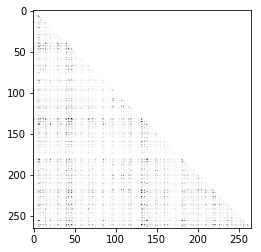

In [10]:
plt.imshow(pairs, cmap="Greys");

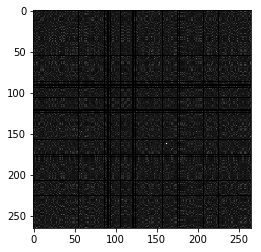

In [11]:
nDrafts = draftCount
prob = pairs*1.0 # Make a copy, and also make symmetric

for i in range(nCards):
    for j in range(i+1):
        if freq[i]>0 and freq[j]>0:
            prob[i,j] = prob[i,j]/float(freq[i])/float(freq[j])*nDrafts
            prob[j,i] = prob[i,j]
        
dist = (1-0.99*prob/prob.max())
plt.imshow(dist, cmap="Greys");

In [12]:
# Debugging: a list of cards that weren't drafted, but are in the db
for i in range(nCards):
    if freq[i]==0:
        print(cardlist[i])
        del cardpicks[cardlist[i]] # Remove undrafted cards from the dictionary

desperate_lunge
forest
gideon's_battle_cry
gideon's_company
gideon_the_oathsworn
guildpact_informant
island
jace's_projection
jace's_ruse
jace_arcane_strategist
mountain
orzhov_guildgate
plains
simic_guildgate
swamp
tezzeret_master_of_the_bridge


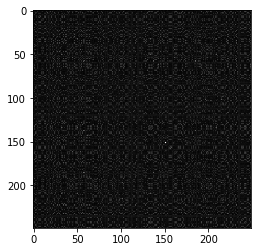

In [13]:
# Remove missing cards from other arrays
# (I make copies of both arrays for some reason, just in case)

dist2 = dist.copy()
dist2 = dist2[freq>0,:]
dist2 = dist2[:,freq>0] # For some reason if I try to subset both rows and columns together, it outputs something stupid
plt.imshow(dist2, cmap="Greys");

freq2 = freq[freq>0]

In [15]:
fit = skm.locally_linear_embedding(dist2, n_components=2, n_neighbors=len(freq2)-1)
fit = fit[0] # For some reason it returns a tuple

#embedding = MDS(n_components=2, dissimilarity='precomputed', max_iter=1000, eps=0.0001)
#fit = embedding.fit_transform(dist2)

In [16]:
df = pd.DataFrame({
        'avg'   : [np.mean(cardpicks[card]) for card in cardpicks],
        'var'   : [np.var(cardpicks[card]) for card in cardpicks],
        'count' : [len(cardpicks[card]) for card in cardpicks],
        'color' : [getCardColor(thisSet[card]) for card in cardpicks],
        'rarity': [thisSet[card]['rarity'] for card in cardpicks],
        'legendary' : [1 if isLegendary(thisSet[card]) else 0 for card in cardpicks],
        'x' : fit[:,0],
        'y' : fit[:,1],
        'freq': freq2[:]
    }, list(cardpicks.keys()))

# Now some torturous attempt to use proper color names, while retaining their sequence
colorName = {0:"C", 1:"Multi", 2:"W", 3:"U", 4:"B", 5:"R", 6:"G"}
df['color'] = df.color.map(colorName)
from pandas.api.types import CategoricalDtype
ctype = CategoricalDtype(categories=["C","Multi","W","U","B","R","G"],ordered=True)
df['color'] = df['color'].astype(ctype)

df.head()

,avg,var,count,color,rarity,legendary,x,y,freq
ahn-crop_invader,9.491117,9.833083,7768,R,common,0,0.053610,0.102627,23070
aid_the_fallen,6.744952,7.260780,4309,B,common,0,0.058228,-0.100280,12597
ajani's_pridemate,4.114521,4.577815,2183,W,uncommon,0,-0.073101,-0.021006,6226
ajani_the_greathearted,1.551777,1.070606,1941,Multi,rare,1,-0.102243,0.001643,8018
angrath's_rampage,7.538293,15.976834,5484,Multi,uncommon,0,0.073395,0.016993,12383


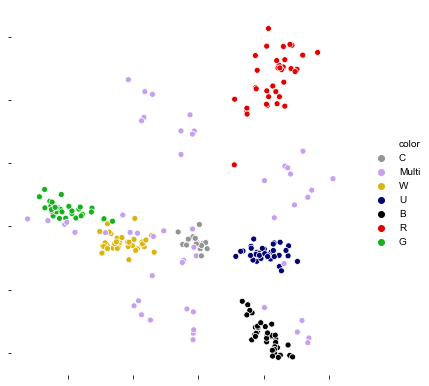

In [17]:
#%matplotlib inline

myPal = sns.xkcd_palette(["grey","lavender","gold","deep blue","black","red","green"])
s = sns.relplot(data=df,x="x",y="y",hue="color",palette=myPal)
s.fig.set_size_inches(7,6)
sns.set_style("white")
s.despine(left=True,bottom=True)
s.set(xticklabels=[],yticklabels=[],xlabel='',ylabel='');

In [18]:
# Save the data.
# Note, it saves to gitHub-visible folder, not to hidden 'data' folder:

df.to_csv('Arseny/basic_data_'+setName+'.csv', index_label="name")
np.savetxt('Arseny/distances_'+setName+'.csv', dist2, delimiter=",")

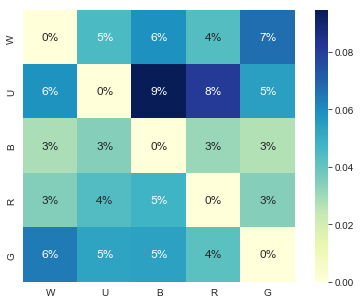

In [19]:
ax = sns.heatmap(guilds/np.sum(guilds), annot=True, fmt="2.0%", cmap="YlGnBu", annot_kws={"size": 12})
ax.set_aspect('equal')
ax.figure.set_size_inches(7,5)
ax.set_xticklabels(["W","U","B","R","G"]); # suppress output, or it returns something
ax.set_yticklabels(["W","U","B","R","G"]); 

In [20]:
# Top picks:
df.sort_values(by=['avg'], ascending=True).head(12)

,avg,var,count,color,rarity,legendary,x,y,freq
liliana_dreadhorde_general,1.000000,0.000000,1048,B,mythic,1,0.036991,-0.070093,2821
god-eternal_oketra,1.000000,0.000000,773,W,mythic,1,-0.053692,-0.015962,2296
god-eternal_bontu,1.001621,0.001618,617,B,mythic,1,0.039240,-0.066561,1750
sarkhan_the_masterless,1.002469,0.002463,1215,R,rare,1,0.044172,0.108906,3465
god-eternal_rhonas,1.002886,0.002878,693,G,mythic,1,-0.081333,0.014472,2050
ilharg_the_raze-boar,1.002999,0.002990,667,R,mythic,1,0.027681,0.100655,1861
jace_wielder_of_mysteries,1.003493,0.003481,1145,U,rare,1,0.048128,-0.023060,3823
chandra_fire_artisan,1.003680,0.003666,1087,R,rare,1,0.052249,0.107267,3247
awakening_of_vitu-ghazi,1.003835,0.003820,1043,G,rare,0,-0.099099,0.015757,2992
finale_of_eternity,1.004115,0.004098,486,B,mythic,0,0.043060,-0.085668,1450


In [21]:
# Top controversial cards (without correction for 'intrinsic controversy')
df.sort_values(by=['var'], ascending=False).head(12)

,avg,var,count,color,rarity,legendary,x,y,freq
niv-mizzet_reborn,9.217124,19.746140,2114,Multi,mythic,1,-0.004532,-0.002066,6545
role_reversal,8.630047,18.389582,3195,Multi,rare,0,0.050528,0.036219,8240
tamiyo_collector_of_tales,7.196796,17.926599,4182,Multi,rare,1,-0.034437,-0.007950,10624
tenth_district_legionnaire,6.993457,17.560098,3974,Multi,uncommon,0,-0.006430,0.088306,9986
teferi_time_raveler,6.466840,17.067602,5775,Multi,rare,1,-0.003478,-0.016526,14253
heartwarming_redemption,8.429731,16.568756,1971,Multi,uncommon,0,-0.003177,0.075498,6439
rubblebelt_rioters,7.484562,16.533089,2753,Multi,uncommon,0,-0.040930,0.106639,7905
angrath's_rampage,7.538293,15.976834,5484,Multi,uncommon,0,0.073395,0.016993,12383
pledge_of_unity,8.657012,15.866252,6767,Multi,uncommon,0,-0.100562,0.003260,16030
mayhem_devil,7.229047,15.857674,3305,Multi,uncommon,0,0.086610,0.028661,8951
